In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
print(os.getcwd())

C:\Users\rusmch\Desktop\File\ALL\Python_script


# Алгоритмы кластеризации. Бизнес кейсы

# 1. DBSCAN

Плотностной алгоритм кластеризации. Разделяет области с высокой плотностью точек и низкой плотностью точек.

Требует задания двух параметров : ε-окрестности, k-минимальное количество точек в кластере, в качестве меры расстояния, как правило Евклидова метрика.

**Основные термины:** 

*Основная точка* — точка имеющая ≥ k соседей в ε окрестности.
*Граничная точка* — не основная точка, имеющая  хотя бы одну основную точку в ε окрестности.
*Шумовая точка* — ни основная, ни граничная.

**Алгоритм:**

Вход: обучающая выборка, параметры ε, k

1. Определить основные, граничные и шумовые   точки для параметров ε, k

2. Создать граф, в котором основные точки соединены, если они находятся на расстоянии <= ε

3. Найти связанные компоненты графа

4. Присвоить все граничные точки  к ближайшим связанным компонентам.


**Преимущества:**

* Сбособен обнаруживать выбросы
* Сложность выполнения в парадигме BigO: O(NlogN)
* Кластера произвольной формы
* Не требует количество кластеров

**Недостатки:**

* Граничные точки, могут принадлежать нескольким кластерам
* Плохо работает с данными с большой разницей в плотности, поскольку не удается выбрать приемлемую для всех кластеров комбинацию параметров.
* Выбор ε окрестности затруднителен (можно применять подходы схожие с подбором K в K-means)

![DBSCAN.png](https://github.com/max-chernyshov/Image/blob/master/Dbscan.png?raw=true)
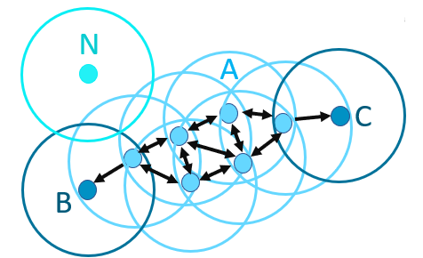

# *Пример: Кластеризация магазинов по расстоянию*

Цель: Ценнообразование,логистика.
Вход: Матрица попарных расстояний между магазинами

In [23]:
df = pd.read_excel('Dist_NN.xlsx',index_col=0,sep=';',decimal=".",encoding='cp1251')
data_clust=df.iloc[:,:-2]

In [8]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=16,min_samples=5) 
dbscan.fit(data_clust) 
df['Кластер']=dbscan.labels_
count = df['Кластер'].nunique()
print("Количество кластеров + Выбросы = ",count)

Количество кластеров + Выбросы =  8


Отобразим на карте. Выбросы выделим красным цветом. Запускать в Jupyter Notebook

In [9]:
import folium
df_map=df.iloc[:,-3:]
m = folium.Map(location=[56.233349,43.834040])
colors=['dodgerblue','lime','magenta','darkblue','grey','deepskyblue','orange']
for i in range(0,len(df_map)):
    Lon=df_map.iloc[i,0]
    Lat=df_map.iloc[i,1]
    if df_map.iloc[i,2]==-1:folium.CircleMarker([Lat,Lon], radius = 5, fill_color='red', color=False,fill_opacity = 0.9).add_to(m)
    else: folium.CircleMarker([Lat,Lon], radius = 5, fill_color=colors[df_map.iloc[i,2]], color=False,fill_opacity = 0.9).add_to(m)    
m

![MAP_1.JPG](https://github.com/max-chernyshov/Image/blob/master/MAP_1.JPG?raw=true)

# 2. K-means кластеризация 

Наиболее популярный алгоритм кластеризации. 

Основная цель - минимизировать суммарное квадратичное отклонение точек кластеров от центров этих кластеров.

Требуемый параметр: количество кластеров K, в качестве меры расстояния-Евклидова метрика.

Как правило, для поиска оптимального количества кластеров применяют "метод локтя". При этом в качестве цели, может выступать максимизация дисперсии, минимизация искажения (внутрикластерного расстояния), минимизация коэффициента силуэта.

**Алгоритм**

Вход: матрица объектов с n признаками,количество кластеров K. Желательно выбирать центроиды, как наиболее удаленные друг от друга точки.

Повторять:

1. Отнести каждый объект к ближайшему центру
2. Вычислить новое положение центров (центр масс кластера).

Пока: 
объекты не перестанут изменяться между кластерами.


**Преимущества:**

* Сравнительно высокая эффективность при простоте реализации
* Высокое качество кластеризации
* Возможность распараллеливания
* Существование множества модификаций

**Недостатки:**

* Количество кластеров является параметром алгоритма
* Инициализация центров кластеров в значительной степени влияет на результат кластеризации.
* Чувствительность к выбросам и шумам
* Возможность сходимости к локальному оптимуму
* Итеративный подход не дает гарантии сходимости к оптимальному решению.
* Алгоритм неприменим к данным, для которых не определено понятие "среднего", например, категориальным данным.




![K_means.JPG](https://github.com/max-chernyshov/Image/blob/master/K_means.JPG?raw=true)
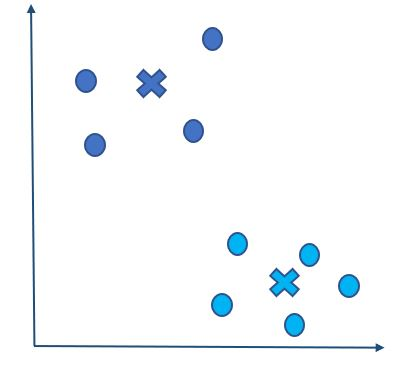

# *Пример: Кластеризация магазинов по конкурентному окружению.*

Цель: Ценнообразование,ассортиментное планирование.

* В качестве признаков использовался коэффициент силы влияния бренда конкурента. Данный коэффициент расчитывался по эвристической формуле, на основе расстояний до точек бренда конкурента, а также экспертных весов для каждого бренда конкурента (считаем что разные бренды по разному влияют на наши магазины)
Необходимо получить 3 кластера:
-слабая конкуренция, -сильная конкуренция, -средняя конкуренция

Идея формулы расчета влияния бренда (в рамках каждого бренда конкурента, влияние каждой точки зависит от расстояни до нашей точки):


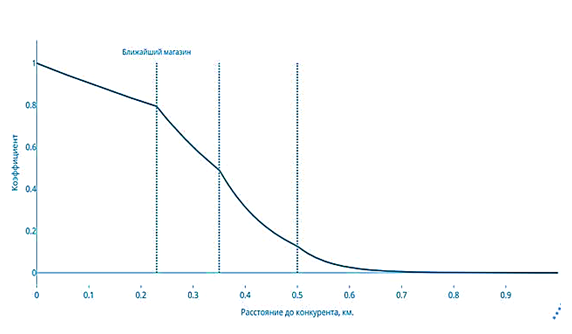

Вход: Матрица коэфициентов по силе бренда конкурентов

In [24]:
df = pd.read_excel('SPB_2.xlsx',index_col=0,sep=';',decimal=".",encoding='cp1251')

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(df.iloc[:,3:])
df['Кластер']=kmeans.labels_

Отобразим кластера на карте.  Запускать в Jupyter Notebook

In [13]:
import folium
df_map=df
m = folium.Map(location=[60.233349,43.834040])
colors=['magenta','darkblue','deepskyblue']
for i in range(0,len(df_map)):
    Lon=df_map.iloc[i,1]
    Lat=df_map.iloc[i,0]
    folium.CircleMarker([Lat,Lon], radius = 5, fill_color=colors[int(df_map.iloc[i,9])], color=False, fill_opacity = 0.9).add_to(m)
m

![MAP_2.JPG](https://github.com/max-chernyshov/Image/blob/master/MAP_2.JPG?raw=true)

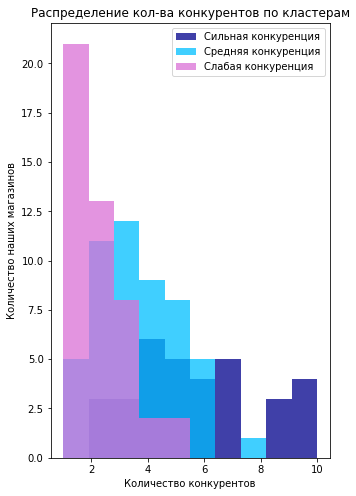

In [55]:
df_1=(df.loc[df['Кластер']==1])
df_2=(df.loc[df['Кластер']==2])
df_3=(df.loc[df['Кластер']==0])
max_nbins = 10
data_range = [min(min(df_1['Конкуренты']), min(df_2['Конкуренты']), min(df_3['Конкуренты'])), max(max(df_1['Конкуренты']), max(df_2['Конкуренты']), max(df_3['Конкуренты']))]
binwidth = (data_range[1] - data_range[0]) / max_nbins
bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
_, ax = plt.subplots(figsize=(5,8))
ax.hist(df_2['Конкуренты'], bins = bins, color = "darkblue", alpha = 0.75, label = "Сильная конкуренция")
ax.hist(df_3['Конкуренты'], bins = bins, color = "deepskyblue", alpha = 0.75, label = "Средняя конкуренция")
ax.hist(df_1['Конкуренты'], bins = bins, color = "orchid", alpha = 0.75, label = "Слабая конкуренция")
ax.set_ylabel("Количество наших магазинов")
ax.set_xlabel("Количество конкурентов")
ax.set_title("Распределение кол-ва конкурентов по кластерам")
ax.legend(loc = 'best')

# 3. Иерархическая кластеризация

Совокупность алгоритмов упорядочивания данных, направленных на создание иерархии (дерева) вложенных кластеров.

**Алгоритм**

Вход:  матрица расстояний M ∈ R^N×N между единичными  кластерами {x1}, . . {xN }.

Повторять:
1. Выбрать ближайшую пару кластеров i и j
2. Объеденить кластера i и j
3. Удалить из матрицы M строки/столбцы с индексами i , j 
и  добавить новую строку для созданного кластера

Пока не останется один кластер.

**Преимущества:**

* Интерпретируемость

**Недостатки:**

* Вычислительная сложность


![Hierarchy.JPG](https://github.com/max-chernyshov/Image/blob/master/Hierarchy.JPG?raw=true)
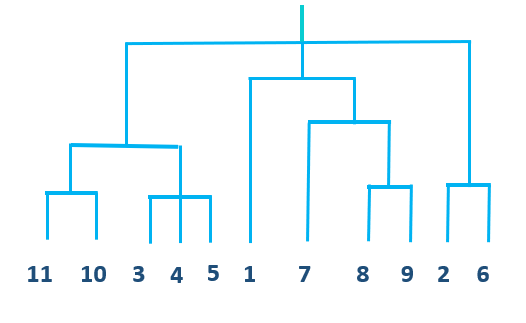

# *Пример: Кластеризация магазинов по профилю продаж.*

Цель: Оптимизация ассортимента,прогнозирование спроса.
Вход: Доли продаж категорий по каждому магазину.

In [25]:
df = pd.read_csv('WORK_MCH_90_LVL1.csv',sep=';',decimal=".",encoding='cp1251')

In [15]:
df_new=df[['STORE_LOCATION_ID','LVL1_NAME','SUM_of_MEAN_of_TOTAL_AMT_pr_reg']].pivot(index='STORE_LOCATION_ID', columns='LVL1_NAME',values='SUM_of_MEAN_of_TOTAL_AMT_pr_reg').fillna(0)
df_new = df_new.iloc[:,0:].div(df_new.sum(axis=1), axis=0)
data_for_clust =  df_new.ix[:,0:].as_matrix()

In [16]:
from scipy.spatial.distance import pdist
dist = pdist(data_for_clust, 'euclidean')

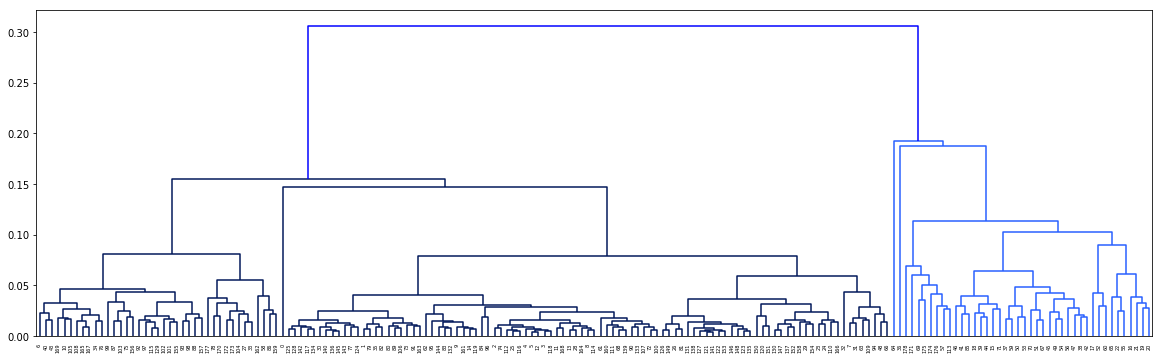

In [17]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(dist, method='ward' )
plt.figure(figsize=(20, 6))
hierarchy.set_link_color_palette(["#001759", "#275fff","#2ecbff"])
dn = hierarchy.dendrogram(Z, color_threshold=0.2)

In [18]:
from scipy.cluster.hierarchy import fcluster
df_k=fcluster(Z, t=0.2, criterion='distance')
df_k

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       2, 1, 2], dtype=int32)

In [19]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data_for_clust,fcluster(Z, t=0.2, criterion='distance'))
print("Коэффициент силуэта равен :", silhouette_avg)

Коэффициент силуэта равен : 0.42919582042714005


In [20]:
df_n=df[['STORE_LOCATION_ID','Latitude','Longitude']].drop_duplicates()
df_n['Кластер']=fcluster(Z, t=0.2, criterion='distance')

Отобразим кластера на карте. Запускать в Jupyter Notebook

In [21]:
import folium
df_map=df_n
m = folium.Map(location=[55.757582,37.631128])
colors=['magenta','darkblue','deepskyblue']
for i in range(0,len(df_map)):
    Lon=df_map.iloc[i,2]
    Lat=df_map.iloc[i,1]
    folium.CircleMarker([Lat,Lon], radius = 5, fill_color=colors[int(df_map.iloc[i,3])], color=False, fill_opacity = 0.9).add_to(m)
m

![MAP_3.JPG](https://github.com/max-chernyshov/Image/blob/master/MAP_3.JPG?raw=true)

# Бизнес-обоснование кластеров см. в презентации к семинару.